In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

np.set_printoptions(suppress=True, precision =4)

In [2]:
class Single_Layer_ReluNet():
    def __init__(self, hidden_num = 1, batch_size = 100, training_epochs = 1000, learning_rate= 0.01):
        # Parameter initiation
        self.hidden_layer = 1
        self.hidden_num = hidden_num
        self.batch_size = batch_size
        self.training_epochs = training_epochs
        self.learning_rate= learning_rate
        # clear previous graph
        tf.reset_default_graph()
        # Network Defination
        self.X = tf.placeholder("float")
        self.Y = tf.placeholder("float")
        self.create_relu_net()
            
    def create_relu_net(self):
        # hidden layer        
        self.hs = []
        self.bs = []
        for i in range(self.hidden_num):
            W1 =  tf.constant([[1., -1.]], dtype =tf.float32)
            b1 = tf.Variable(tf.random_uniform(minval=0+1.0*i/self.hidden_num, maxval=1.0*(i+1)/self.hidden_num, shape=[1]), dtype =tf.float32)
            self.bs.append(b1)
            self.hs.append(tf.nn.relu(tf.matmul(self.X, W1)+tf.stack([-b1, b1], axis = 1)))

        # output layer
        self.WOut = tf.Variable(tf.random_normal([self.hidden_num*2, 1]))
        self.bOut = tf.Variable(tf.constant(0.0, shape=[1]))
        self.y_model = tf.matmul(tf.reshape(tf.stack(self.hs, axis = 1), [-1,self.hidden_num*2]), self.WOut) + self.bOut
        self.cost = tf.reduce_mean(tf.square(self.Y - self.y_model)) 

        # optimization
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.cost)
        # initilize
        self.sess = tf.Session()
        self.init_op = tf.group(
                tf.local_variables_initializer(),
                tf.global_variables_initializer()
                )
        self.sess.run(self.init_op)
            
    def train(self, train_x, train_y):
        self.err_train = []
        train_size = train_x.shape[0]
        training_data = np.hstack([train_x,train_y])
        mini_batches = [training_data[k:k+self.batch_size] for k in range(0, train_size, self.batch_size)]
        for epoch in range(self.training_epochs):
            for i in range(len(mini_batches)):
                self.sess.run(self.train_op, feed_dict={self.X: mini_batches[i][:,:1], self.Y: mini_batches[i][:,1:]})
            if (epoch + 1) % 500 == 0:
                err_train = self.sess.run(self.cost, feed_dict={self.X: train_x, self.Y: train_y})
                self.err_train.append(err_train)
                print("Epoch ", epoch + 1, " Loss:", err_train)
        pred_train = self.sess.run(self.y_model, feed_dict={self.X: train_x, self.Y: train_y})
        return pred_train 
        
    def predict(self, test_x):
        for i in range(self.hidden_layer):
            print("The " + str(i+1) +" Layer:",np.round(self.sess.run(self.hs[i], feed_dict={self.X: test_x}),3))
        pred = self.sess.run([self.y_model], feed_dict={self.X: test_x})
        print("The Final Output:",pred)
        return pred
    
    def get_knots(self):
        all_bs = self.sess.run(self.bs)
        all_knots = [] 
        for bs in all_bs:
            all_knots.append(bs[0])
        return np.sort(all_knots)
    
    def evaluate(self, true_signal, pred_signal, true_knots, train_size):
        # mse
        mse = np.mean((true_signal - pred_signal)**2)
        # knots
        true_knots = np.array(true_knots)
        true_knot_number = len(true_knots)
        pred_knots = np.sort(np.unique(np.round(self.get_knots()*train_size)))
        pred_knot_number = len(pred_knots)
        diff_knot_number = pred_knot_number - true_knot_number
        # hausdorff
        temp1 = []; temp2 = []
        for i in range(true_knot_number):
            temp1.append(min(abs(true_knots[i] - pred_knots)))
        d1 = max(temp1)    
        for i in range(pred_knot_number):
            temp2.append(min(abs(pred_knots[i] - true_knots)))
        d2 = max(temp2)
        hausdorff = max(d1,d2)/len(true_signal)
        print("MSE:",np.round(mse, 4))
        print("The difference of knots:", diff_knot_number)
        print("The hausdorff distance:", np.round(hausdorff, 4))

    def summary(self, train_x, noise_signal, true_signal=None, scaler = None, true_knots = []):  
        train_size = len(noise_signal)
        x_label = train_x*train_size
        
        all_bs = self.sess.run([self.bs])

        all_knots = np.unique(np.round(self.get_knots()*train_size))
        knots_ls = np.array(all_knots)[(np.array(all_knots)>0)&(np.array(all_knots)<train_size)]
        print("Unique Knots:", knots_ls)
        # Prediction 
 
        if (true_signal is not None) & (scaler is not None):
            pred_signal = scaler.inverse_transform(self.sess.run(self.y_model , feed_dict={self.X: train_x})) 
            
            # Plot
            plt.figure(figsize=(10,4))
            plt.plot(x_label,noise_signal)
            plt.plot(x_label,pred_signal, c="red")
            plt.plot(x_label,true_signal, dashes=[6, 2], c="black")
            plt.scatter(knots_ls, np.min(noise_signal) - 0.5*np.ones(len(knots_ls)), color = "green")
            plt.legend(["Observed","Pred","True", "Knots"])
            
            # Evaluate
            if (len(true_knots) >0): 
                self.evaluate(true_signal, pred_signal, true_knots, train_size)

# Test Example: Wave1

In [3]:
DataNum = 1408
wave1 = np.zeros([DataNum, 1])
intercept = 1
tau = [1, 256, 512, 768, 1024, 1152, 1280, 1344, 1408]
init_slope = 2**(-8)
slope = [0, 1*2**(-6), -2*2**(-6), 3*2**(-6), -4*2**(-6), 5*2**(-6), -6*2**(-6), 7*2**(-6)]
wave1[0] = intercept
for i in range(8):
    wave1[tau[i]:tau[i+1], 0] = wave1[tau[i]-1] + (init_slope - sum(slope[0:i+1])) * np.array(range(1,tau[i+1]-tau[i]+1))
    
wave1_noise = wave1 + np.random.normal(0,1,DataNum).reshape([-1,1])
scaler = MinMaxScaler()
train_x = np.reshape(np.linspace(1, DataNum, DataNum)/DataNum, [-1,1])
train_y = scaler.fit_transform(wave1_noise)

In [4]:
model = Single_Layer_ReluNet(hidden_num = 20, batch_size = 700, training_epochs = 10000, learning_rate= 0.001)
pred_train = model.train(train_x, train_y)

Epoch  500  Loss: 0.01502876
Epoch  1000  Loss: 0.009609167
Epoch  1500  Loss: 0.008903828
Epoch  2000  Loss: 0.008520702
Epoch  2500  Loss: 0.008218882
Epoch  3000  Loss: 0.0080078
Epoch  3500  Loss: 0.007885131
Epoch  4000  Loss: 0.007837325
Epoch  4500  Loss: 0.007801102
Epoch  5000  Loss: 0.007786103
Epoch  5500  Loss: 0.0077772667
Epoch  6000  Loss: 0.00777134
Epoch  6500  Loss: 0.0077672317
Epoch  7000  Loss: 0.007761489
Epoch  7500  Loss: 0.00775996
Epoch  8000  Loss: 0.00775892
Epoch  8500  Loss: 0.007758469
Epoch  9000  Loss: 0.0077620465
Epoch  9500  Loss: 0.007757919
Epoch  10000  Loss: 0.007757826


Unique Knots: [  37.  262.  392.  456.  496.  522.  529.  767.  799. 1029. 1128. 1129.]
MSE: 0.2572
The difference of knots: 7
The hausdorff distance: 0.2884


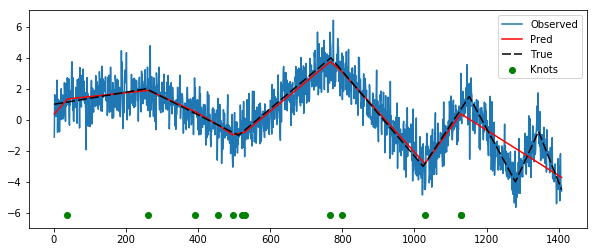

In [5]:
model.summary(train_x, wave1_noise, wave1, scaler, [256, 512, 768, 1024, 1152, 1280, 1344])

# Test Example: Wave2

In [6]:
DataNum = 1500
wave2 = np.zeros([DataNum,1])
intercept = 0
tau = [1, 150, 300, 450, 600, 750, 900, 1050, 1200, 1350, 1500]
init_slope = 2**(-6)
slope = [0, 2**(-5), -2**(-5),  2**(-5), -2**(-5), 2**(-5), -2**(-5), 2**(-5), -2**(-5), 2**(-5)]
wave2[0] = intercept
for i in range(10):
    wave2[tau[i]:tau[i+1],0] = wave2[tau[i]-1] + (init_slope - sum(slope[0:i+1])) * np.array(range(1,tau[i+1]-tau[i]+1))

wave2_noise = wave2 + np.random.normal(0,1,DataNum).reshape([-1,1])

scaler = MinMaxScaler()
train_x = np.reshape(np.linspace(1, DataNum, DataNum)/DataNum, [-1,1])
train_y = scaler.fit_transform(wave2_noise)

In [7]:
model = Single_Layer_ReluNet(hidden_num = 30, batch_size = 750, training_epochs = 10000, learning_rate= 0.001)
pred_train = model.train(train_x, train_y)

Epoch  500  Loss: 0.025221694
Epoch  1000  Loss: 0.022704871
Epoch  1500  Loss: 0.021266734
Epoch  2000  Loss: 0.020238148
Epoch  2500  Loss: 0.01949847
Epoch  3000  Loss: 0.019044658
Epoch  3500  Loss: 0.018629627
Epoch  4000  Loss: 0.018204028
Epoch  4500  Loss: 0.017776717
Epoch  5000  Loss: 0.017419292
Epoch  5500  Loss: 0.017204568
Epoch  6000  Loss: 0.017085817
Epoch  6500  Loss: 0.0170403
Epoch  7000  Loss: 0.016977584
Epoch  7500  Loss: 0.01695938
Epoch  8000  Loss: 0.016942896
Epoch  8500  Loss: 0.016937755
Epoch  9000  Loss: 0.01693027
Epoch  9500  Loss: 0.016925436
Epoch  10000  Loss: 0.016928636


Unique Knots: [ 133.  165.  287.  319.  429.  439.  597.  749.  905.  911. 1020. 1048.
 1192. 1200. 1284. 1350.]
MSE: 0.0159
The difference of knots: 8
The hausdorff distance: 0.1547


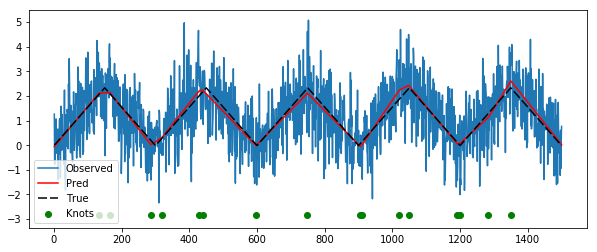

In [8]:
model.summary(train_x, wave2_noise, wave2, scaler, [150, 300, 450, 600, 750, 900, 1050, 1200, 1350])

# Test Example: Doppler

In [9]:
def doppler(DataNum, noise_level):
    x = np.linspace(1, DataNum, DataNum)/DataNum
    y0 = np.sqrt(x*(1-x))*np.sin((2.1*np.pi)/(x+0.05)) 
    y = y0 + noise_level*np.random.normal(0, 1, DataNum)
    return x, y , y0

DataNum = 1024
X, Y, Y0 = doppler(DataNum, 0.1)
X = X.reshape([-1,1])
Y = Y.reshape([-1,1])

scaler = MinMaxScaler()
train_x = np.reshape(np.linspace(1, DataNum, DataNum)/DataNum, [-1,1])
train_y = scaler.fit_transform(Y)

In [10]:
model = Single_Layer_ReluNet(hidden_num = 50, batch_size = 500, training_epochs = 10000, learning_rate= 0.001)
pred_train = model.train(train_x, train_y)

Epoch  500  Loss: 0.03241351
Epoch  1000  Loss: 0.021472018
Epoch  1500  Loss: 0.019380849
Epoch  2000  Loss: 0.01812816
Epoch  2500  Loss: 0.01683914
Epoch  3000  Loss: 0.01579941
Epoch  3500  Loss: 0.0153305605
Epoch  4000  Loss: 0.015012068
Epoch  4500  Loss: 0.014751162
Epoch  5000  Loss: 0.014496548
Epoch  5500  Loss: 0.014377877
Epoch  6000  Loss: 0.014119693
Epoch  6500  Loss: 0.014020639
Epoch  7000  Loss: 0.013815919
Epoch  7500  Loss: 0.013686019
Epoch  8000  Loss: 0.013558799
Epoch  8500  Loss: 0.013443999
Epoch  9000  Loss: 0.013349764
Epoch  9500  Loss: 0.013231205
Epoch  10000  Loss: 0.013161036


Unique Knots: [   4.   48.   86.   98.  108.  176.  201.  232.  284.  348.  423.  429.
  531.  577.  578.  599.  672.  683.  715.  737.  785.  807.  818.  823.
  830.  876.  881.  946.  947.  957. 1004.]


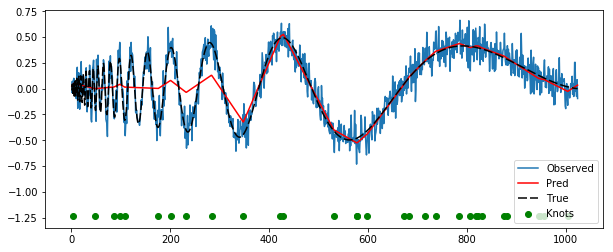

In [11]:
model.summary(train_x, Y, Y0, scaler)